In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
import os
from keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers

In [ ]:
train_dir='/content/drive/MyDrive/McHacks/Dataset/Train'

In [ ]:
labels = ['Blackhead', 'Cyst', 'Papule', 'Pustule', 'Whitehead']

In [ ]:
print("class : ")
for i in range(len(labels)):
  print(i, end = " ")
  print (labels[i])

class : 
0 Blackhead
1 Cyst
2 Papule
3 Pustule
4 Whitehead


In [ ]:
print('Number of classes: ', len(labels))

Number of classes:  5


In [ ]:
module_selection = ("mobilenet_v3", 224, 1280)
handle_base, pixels, FV_SIZE = module_selection
MODULE_HANDLE = "https://www.kaggle.com/models/google/mobilenet-v3/frameworks/TensorFlow2/variations/large-075-224-classification/versions/1".format(handle_base)
IMAGE_SIZE = (pixels, pixels)
BATCH_SIZE = 25

In [ ]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale = 1./255,
    rotation_range=40,
    horizontal_flip=True,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    fill_mode='nearest',
    validation_split=0.3
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    subset="training",
    shuffle=True,
    seed=42,
    color_mode="rgb",
    class_mode="categorical",
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE
)
validation_generator = train_datagen.flow_from_directory(
    train_dir,
    shuffle=False,
    seed=42,
    color_mode="rgb",
    class_mode="categorical",
    subset="validation",
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE
)

Found 70 images belonging to 5 classes.
Found 30 images belonging to 5 classes.


In [ ]:
feature_extractor = hub.KerasLayer(MODULE_HANDLE,input_shape=IMAGE_SIZE+(3,),output_shape=[FV_SIZE])

In [ ]:
do_fine_tuning = False
if do_fine_tuning:
  feature_extractor.trainable = True
  for layer in base_model.layers[-30]:
    layer.trainable = True
  else:
    feature_extractor.trainable = False

In [ ]:
print("Building model with", MODULE_HANDLE)
model = tf.keras.Sequential([
    feature_extractor,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(train_generator.num_classes, activation='softmax', kernel_regularizer=tf.keras.regularizers.l2(0.0001))
])
model.summary()

Building model with https://www.kaggle.com/models/google/mobilenet-v3/frameworks/TensorFlow2/variations/large-075-224-classification/versions/1
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1001)              4013897   
                                                                 
 flatten (Flatten)           (None, 1001)              0         
                                                                 
 dense (Dense)               (None, 512)               513024    
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 5)                 2565      
                                                                 
Total params: 4529486 (17.28 MB)
Trainable p

In [ ]:
LEARNING_RATE = 0.001
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate = LEARNING_RATE),
    loss ='categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
EPOCHS=24
history=model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples//train_generator.batch_size,
    epochs=EPOCHS,
    validation_data = validation_generator,
    validation_steps = validation_generator.samples//validation_generator.batch_size
)

Epoch 1/24
2/2 [==============================] - 29s 18s/step - loss: 2.4964 - accuracy: 0.2667 - val_loss: 1.5901 - val_accuracy: 0.3200
Epoch 2/24
2/2 [==============================] - 5s 4s/step - loss: 1.3372 - accuracy: 0.6600 - val_loss: 1.1390 - val_accuracy: 0.4800
Epoch 3/24
2/2 [==============================] - 5s 3s/step - loss: 0.9049 - accuracy: 0.6667 - val_loss: 1.9899 - val_accuracy: 0.4800
Epoch 4/24
2/2 [==============================] - 5s 4s/step - loss: 0.6984 - accuracy: 0.8000 - val_loss: 1.5213 - val_accuracy: 0.5200
Epoch 5/24
2/2 [==============================] - 4s 2s/step - loss: 0.3905 - accuracy: 0.8000 - val_loss: 1.8394 - val_accuracy: 0.4800
Epoch 6/24
2/2 [==============================] - 5s 4s/step - loss: 0.3524 - accuracy: 0.8444 - val_loss: 1.1120 - val_accuracy: 0.6800
Epoch 7/24
2/2 [==============================] - 5s 4s/step - loss: 0.3685 - accuracy: 0.8889 - val_loss: 1.1505 - val_accuracy: 0.6000
Epoch 8/24
2/2 [=======================

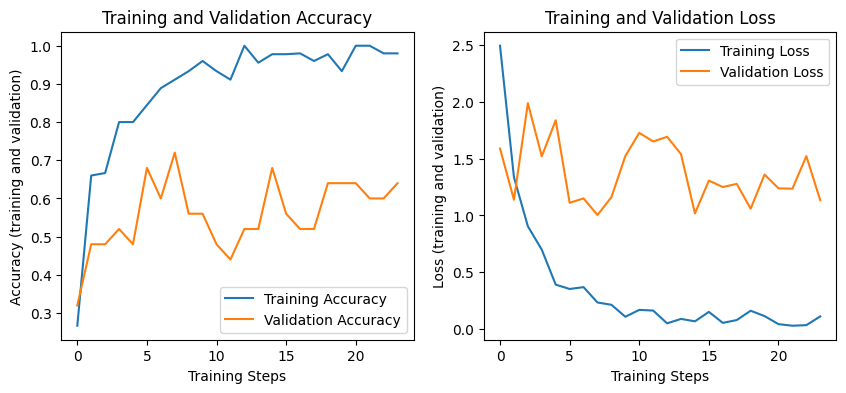

In [ ]:
import matplotlib.pylab as plt
import numpy as np

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(10, 4))
plt.subplot (1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.ylabel("Accuracy (training and validation)")
plt.xlabel("Training Steps")

plt.subplot (1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot (epochs_range, val_loss, label='Validation Loss')
plt.legend (loc='upper right')
plt.title('Training and Validation Loss')
plt.ylabel("Loss (training and validation)")
plt.xlabel ("Training Steps")
plt.show()

1/1 [==============================] - 1s 650ms/step
class: Whitehead, confidence: 0.636049


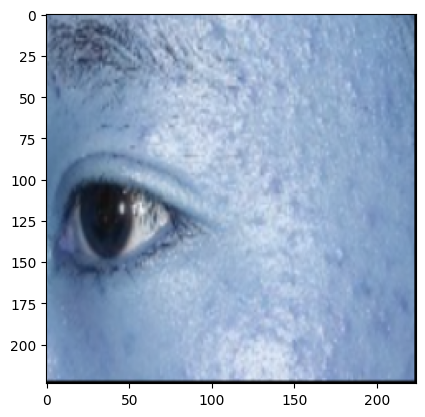

<Figure size 640x480 with 0 Axes>

1/1 [==============================] - 0s 57ms/step
class: Whitehead, confidence: 0.729302


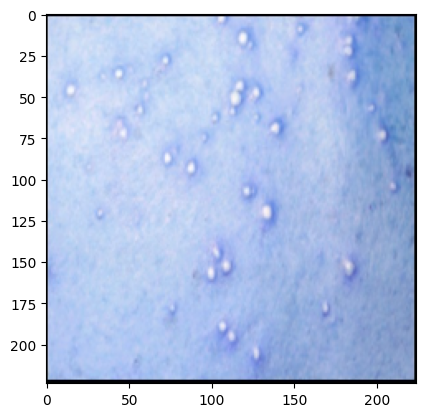

1/1 [==============================] - 0s 54ms/step
class: Papule, confidence: 0.547109


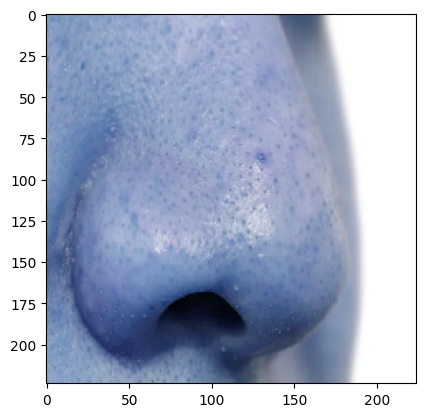

<Figure size 640x480 with 0 Axes>

1/1 [==============================] - 0s 77ms/step
class: Papule, confidence: 0.613401


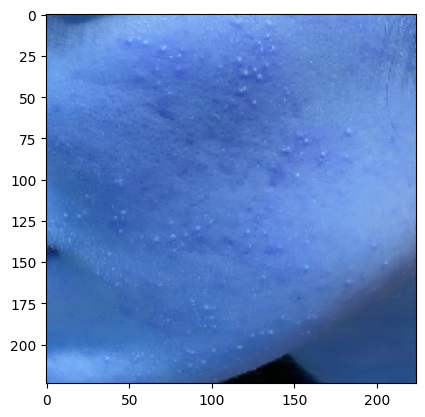

<Figure size 640x480 with 0 Axes>

1/1 [==============================] - 0s 95ms/step
class: Whitehead, confidence: 0.996389


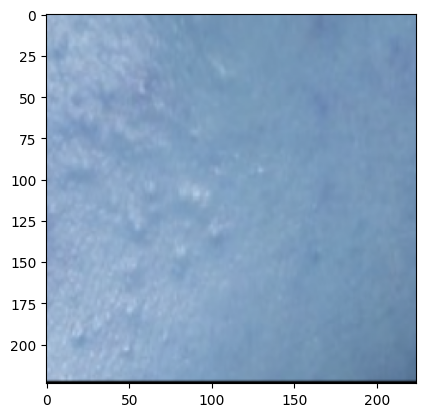

<Figure size 640x480 with 0 Axes>

1/1 [==============================] - 0s 84ms/step
class: Papule, confidence: 0.850562


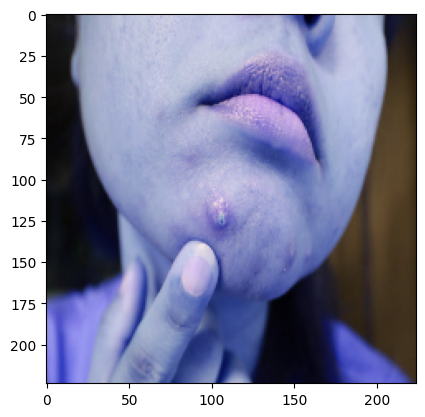

<Figure size 640x480 with 0 Axes>

1/1 [==============================] - 0s 89ms/step
class: Papule, confidence: 0.481423


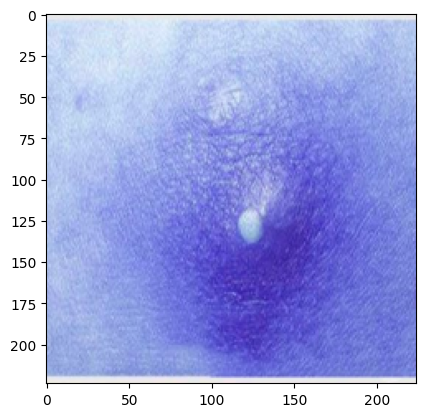

<Figure size 640x480 with 0 Axes>

1/1 [==============================] - 0s 74ms/step
class: Pustule, confidence: 0.778672


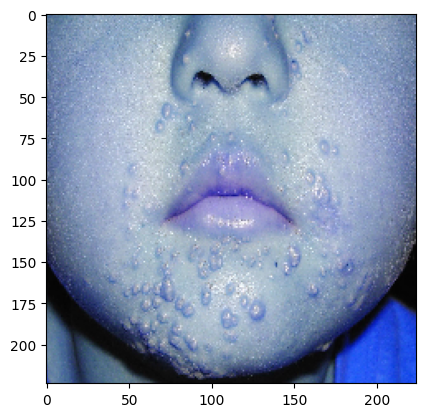

<Figure size 640x480 with 0 Axes>

1/1 [==============================] - 0s 99ms/step
class: Pustule, confidence: 0.523947


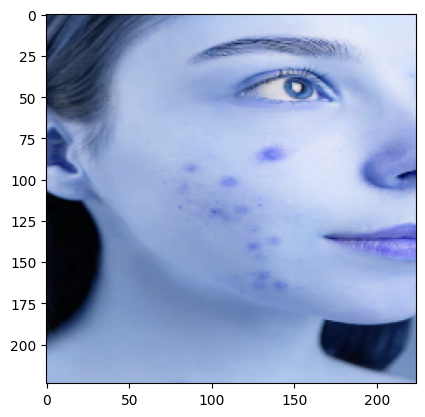

<Figure size 640x480 with 0 Axes>

1/1 [==============================] - 0s 45ms/step
class: Whitehead, confidence: 0.878605


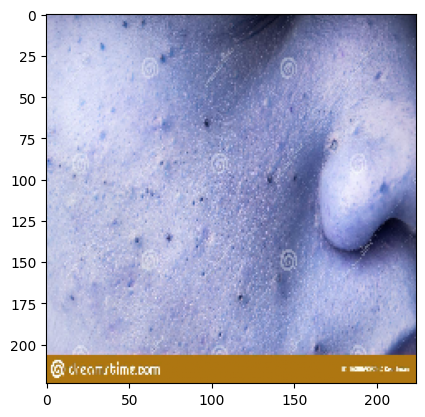

<Figure size 640x480 with 0 Axes>

1/1 [==============================] - 0s 76ms/step
class: Papule, confidence: 0.499128


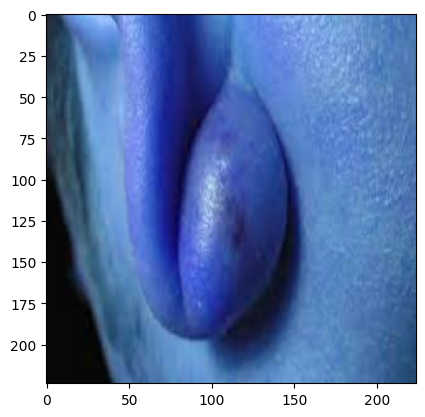

<Figure size 640x480 with 0 Axes>

1/1 [==============================] - 0s 47ms/step
class: Papule, confidence: 0.972798


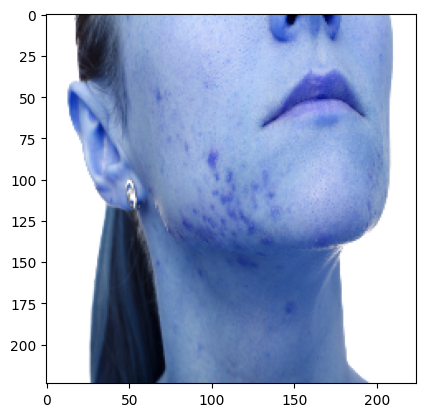

<Figure size 640x480 with 0 Axes>

1/1 [==============================] - 0s 72ms/step
class: Whitehead, confidence: 0.996093


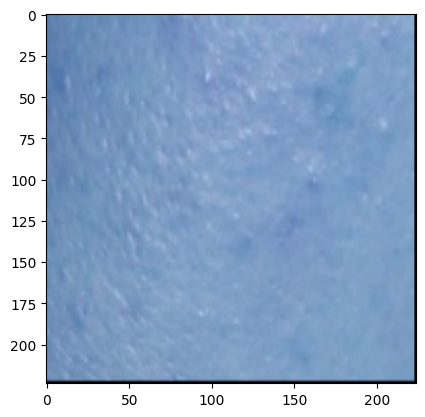

<Figure size 640x480 with 0 Axes>

1/1 [==============================] - 0s 61ms/step
class: Papule, confidence: 0.961427


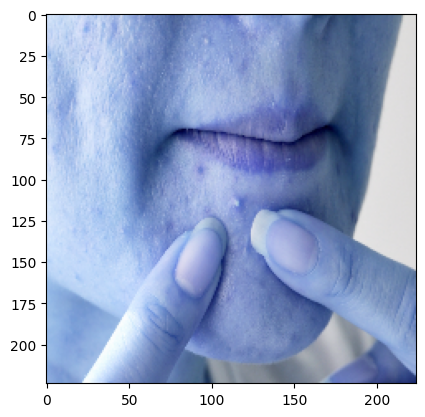

<Figure size 640x480 with 0 Axes>

1/1 [==============================] - 0s 77ms/step
class: Pustule, confidence: 0.517765


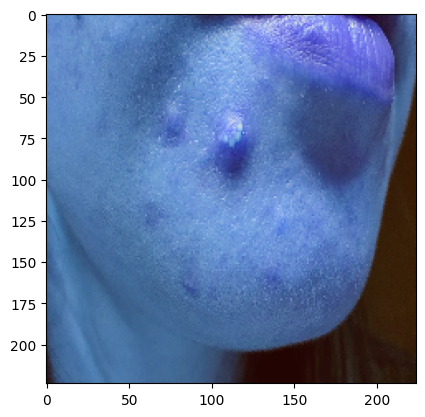

<Figure size 640x480 with 0 Axes>

1/1 [==============================] - 0s 98ms/step
class: Papule, confidence: 0.852769


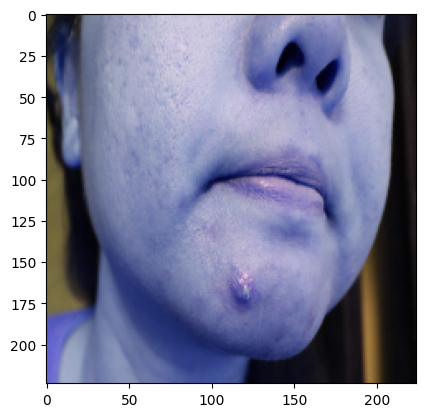

<Figure size 640x480 with 0 Axes>

1/1 [==============================] - 0s 101ms/step
class: Cyst, confidence: 0.811383


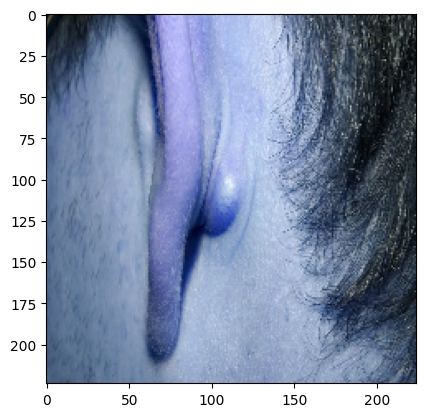

<Figure size 640x480 with 0 Axes>

In [ ]:
import random
import cv2
def upload (filename):
  img = cv2.imread(os.path.join(train_dir, filename))
  img = cv2.resize(img, (224, 224))
  img = img/255
  return img

def pre_result(image):
  x = model.predict(np.asarray([img]))[0]
  classx = np.argmax(x)

  return {labels[classx]: x[classx]}

images = random.sample(validation_generator.filenames, 17)

for idx, filename in enumerate(images):
  img = upload (filename )
  prediction = pre_result(img)
  print("class: %s, confidence: %f" % (list(prediction.keys())[0], list(prediction.values())[0]))
  plt.imshow (img)
  plt.figure (idx)
  plt.show()

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
predictions1 = model.predict(validation_generator, steps=len(validation_generator))
y = np.argmax(predictions1, axis=1)

print('Classification Report')
cr = classification_report(y_true=validation_generator.classes, y_pred=y, target_names=validation_generator.class_indices)
print(cr)

evaluates = model.evaluate(validation_generator)

print(evaluates)

2/2 [==============================] - 3s 170ms/step
Classification Report
              precision    recall  f1-score   support

   Blackhead       1.00      1.00      1.00         6
        Cyst       0.80      0.67      0.73         6
      Papule       0.33      0.33      0.33         6
     Pustule       0.43      0.50      0.46         6
   Whitehead       0.67      0.67      0.67         6

    accuracy                           0.63        30
   macro avg       0.65      0.63      0.64        30
weighted avg       0.65      0.63      0.64        30

2/2 [==============================] - 1s 102ms/step - loss: 0.9337 - accuracy: 0.6333
[0.9336738586425781, 0.6333333253860474]


Confusion Matrix


<Axes: >

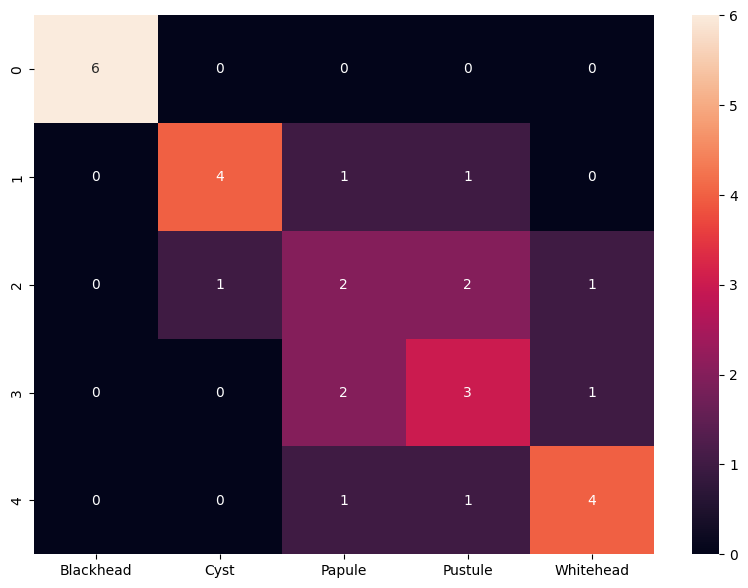

In [ ]:
import pandas as pd
import seaborn as sn
print('Confusion Matrix')
cm = confusion_matrix(validation_generator.classes, y)
df = pd.DataFrame(cm, columns=validation_generator.class_indices)
plt.figure(figsize=(10,7))
sn.heatmap(df, annot=True)

**Export Model to TFLite format**

In [ ]:
t = time.time()

export_path = "/tmp/saved_models{}".format(int(t))
tf.keras.models.save_model(model, export_path)

In [ ]:
reloaded = tf.keras.models.load_model(export_path, custom_objects={'KerasLayer' :hub.KerasLayer})

In [ ]:
def predict_reload(image):
  probabilities = reloaded.predict(np.asarray([img]))[0]
  class_idx = np.argmax(probabilities)

  return {labels[class_idx]: probabilities[class_idx]}

In [ ]:
for idx, filename in enumerate(random.sample(validation_generator.filenames,2)):
  print("SOURCE: class: %s, file: %s" % (os.path.split(filename)[0], filename))

  img = upload(filename)
  prediction = predict_reload(img)
  print("PREDICTION: class: %s, confidence: %f" % (list(prediction.keys())[0], list(prediction.values())[0]))
  plt.imshow(img)
  plt.figure(idx)
  plt.show()

In [ ]:
!mkdir "tflite_models"
TFLITE_MODEL = "tflite_models/model.tflite"

run_model = tf.function(lambda x : reloaded(x))

concrete_func = run_model.get_concrete_function(
    tf.TensorSpec(model.inputs[0].shape, model.inputs[0].dtype)
)

converter = tf.lite.TFLiteConverter.from_concrete_functions([concrete_func])
converted_tflite_model = converter.convert()
open(TFLITE_MODEL, "wb").write(converted_tflite_model)